## <center>CFT Shift 2023: Работа с данными и SQL</center>
___________________________________________________________________________________________________________________________________________

### Введение

В рамках выполнения данного задания нам предстоит создать Postgres БД и наполнить ее данными, а также сделать 5 фич для последующего обучения модели и выполнить ряд запросов на выборку.

В процессе работы будем использовать модуль `psycopg2` (как это читать — я думаю, что правильно сайкопиджидва). Сеть говорит, что это самый популярный и мощный Postgres адаптер для Python. Я раньше работал только с SQLite и MySQL, базы данных были уже готовые, и коннект к ним прозводился достаточно просто через sqlite3, sqlalchemy и т.д. Здесь у нас задача чуть более нетривиальная, так что будем разбираться.

### Создание пустой базы данных

Для начала нам нужно создать пустую Postgres базу данных, чтобы впоследствии заполнить ее таблицами. Postgres был установлен на подсистему Linux для Windows (Ubuntu 22.04).

База данных home_credit была создана в командной строке bash:

`$ sudo -u postgres psql`

И далее в командной строке psql (юзера postgres трогать не будем, создадим новую роль):

`CREATE ROLE cft_shift_user WITH LOGIN PASSWORD 'cft_shift';`

`CREATE DATABASE home_credit WITH OWNER cft_shift_user;`

Далее набрав команду `\l`, можно убедиться, что база данных home_credit успешно создана.

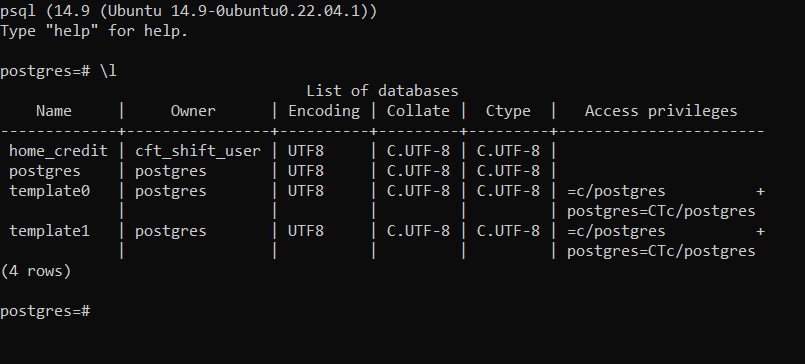

### Создание файлов подключения к базе данных

Для подключения к базе данных, требуется информация о названии БД, юзернейм, пароль, хост и порт (по умолчанию 5432). Теоретически, эту информацию можно хранить в ноутбуке, но это не всегда безопасно. Я решил сделать конфиг-файл `home_credit_db_cred.ini`, где указана необходимая информация. Также в папке utils лежит простой парсер `home_credit_cfg_parser`, который переводит текст из конфиг-файла в dict. Этот словарь впоследствии можно использовать в качестве аргумента в функции или классе для поключения к БД и прочих операций с БД. Таким образом, без конфиг-файла подключиться к БД не получится.

Далее запускается скрипт парсера, который находит конфиг-файл и создает словарь `db_args`:

In [1]:
%run -i ~/data_science/credit_scoring/src/app/utils/home_credit_cfg_parser.py
db_args

{'database': 'home_credit',
 'user': 'cft_shift_user',
 'password': 'cft_shift',
 'host': 'localhost',
 'port': '5432'}

### Создание класса для операций с базой данных

Чтобы делать запросы и прочие операции с базой данных, нам понадобятся два объекта `psycopg2`: connection object и cursor object. Первый отвечает за соединение с БД, в то время как второй позволяет получать информацию от БД на основе SQL-запросов. В принципе, это стандартные способы подключения к БД и извлечения из нее информации с участием Python. Сам код реализовать можно по разному: функции, контекст менеджеры, классы. Попробуем сделать класс c встроенным менеджером контекста. Я считаю, что уже в `__init__` мы можем прописать создание коннекта и курсора, потому что это основа взаимодействия с нашей БД.

Касательно `warnings`, при создании запроса на получение инфы и ее загрузку в `pandas` датафрейм (при выполнении упражнений на запросы) я получал следующее:

> /tmp/ipykernel_138035/2146269486.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

В гугле пишут, что предупреждение появляется в относительно новых версиях `psycopg2`, до этого все работало нормально, да и сейчас все работает нормально. Я проверил запросы на выборку, они отрабатывают корректно. Поэтому я считаю, что данный warning можно игнорировать. 

In [2]:
import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor
import warnings

In [3]:
class PostgresManagement():
    
    def __init__(self, kwargs):      
       
        try:
            self.conn = psycopg2.connect(**kwargs)
            self.cursor = self.conn.cursor(cursor_factory=RealDictCursor)
            print("Postgres server information")
            print(self.conn.get_dsn_parameters(), "\n")
        
        except (Exception, psycopg2.DatabaseError) as error:
            print('Error while fetching data from PostgreSQL', error)

    def __enter__(self):
        return (self.conn, self.cursor)

    @staticmethod
    def send_query(conn, cursor, query, table_name):
        """Execute SQL Query and and commit it to the database"""
        cursor.execute(query)
        conn.commit()
        print(f'{table_name} successfully created or modified')
   
    @staticmethod
    def get_df_from_query(conn, cursor, query): 
        """Execute SQL Query and get Dataframe with pandas"""
        
        with warnings.catch_warnings():
        # ignore warning for non-SQLAlchemy Connecton
        # see github.com/pandas-dev/pandas/issues/45660
            warnings.simplefilter('ignore', UserWarning)
        
            df = pd.read_sql(query, conn)
        return df
    
    def __exit__(self, err_type, err_value, traceback):       
        if err_type and err_value:
            self.conn.rollback()
        
        self.cursor.close()
        self.conn.close()
        
        return False  # здесь нужно четко указать False, чтобы были выведены все ошибки, если они были


### Создание каркаса таблиц

С созданием каркаса таблиц я решил не выпендриваться и сделать их вручную. Так будет больше контроля за процессом, и времени займет не так много, потому что для каждой таблицы все нужно прописать только один раз. Скрипт я делал бы дольше и не факт, что все получилось бы лучше, все-таки я не матерый дата-инженер, а точнее вообще не дата-инженер. Тут логика такая — один раз можно сделать вручную, но если такие базы данных предстоит делать часто (каждую неделю, каждый день), то однозначно нужен скрипт.

Касательно выбора типа данных — в соседнем ноутбуке открываем через `pd.read_csv()` таблицы и смотрим, какие вообще в столбцах есть данные (`describe()`, `value_counts()` в помощь) и соотносим наблюдения с имеющимися типами данных Postgres.

Как выбрать параметр n для VARCHAR? В [PostgreSQL wiki](https://wiki.postgresql.org/wiki/Don%27t_Do_This#Don.27t_use_varchar.28n.29_by_default) находим информацию, согласно которой нет смысла ограничивать количество символов, поскольку это не влияет на производительность. Ограничение имеет смысл, только если мы хотим запретить заполнение таблицы данными, превышающими по длине выставленное ограничение. 

Однако мы будем следить за числовыми данными и выбирать `smallint`, `integer` и `real` соответственно. Список названий столбцов для копипасты легко получить через `df.columns.to_list()`.

Не забудем также назначить в таблицах PRIMARY и FOREIGN ключи. Это основа реляционной БД.

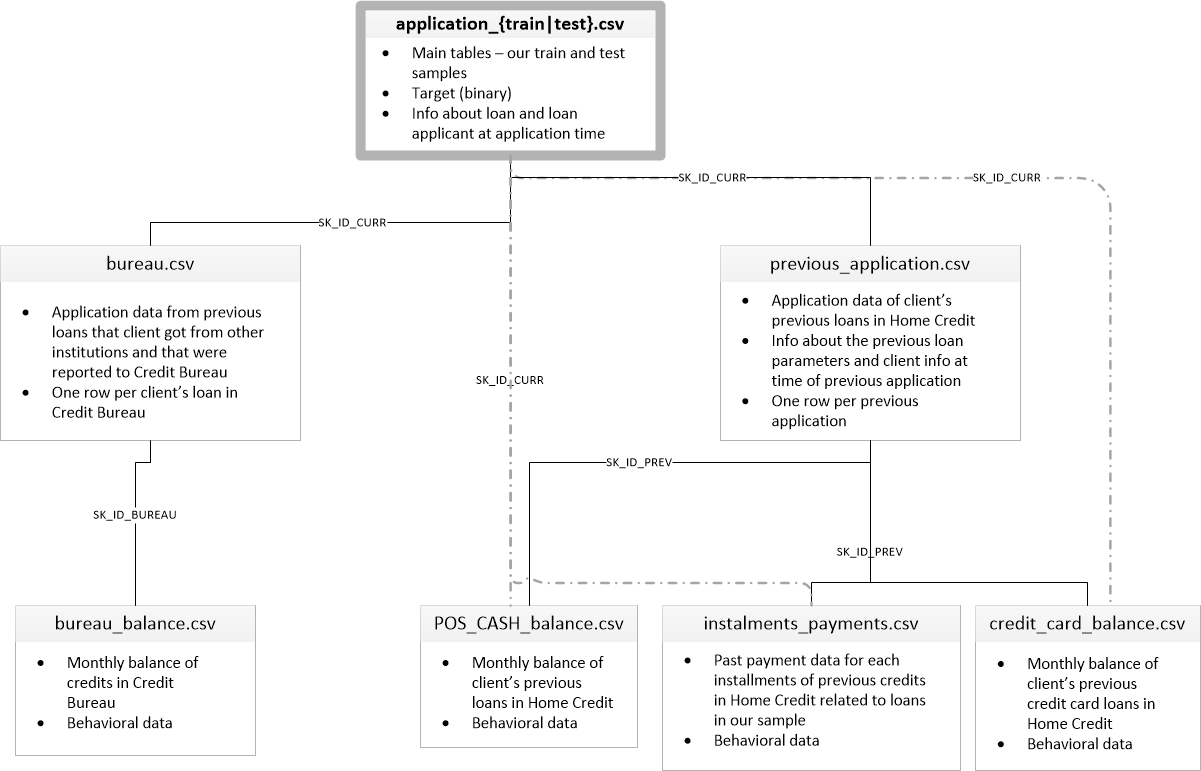

Таким образом, оценив силы и проведя некоторую подготовку, открываем контекст менеджер и пишем:

In [4]:
pg_management_create = PostgresManagement(db_args)

with pg_management_create as (conn, cursor):
    print(conn, '\n')  # можно проверить, что коннект произошел и параметр closed: 0

    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS application_train_test CASCADE; 
    CREATE TABLE application_train_test(
      SK_ID_CURR integer PRIMARY KEY,
      TARGET real,
      NAME_CONTRACT_TYPE varchar,
      CODE_GENDER varchar,
      FLAG_OWN_CAR varchar,
      FLAG_OWN_REALTY varchar,
      CNT_CHILDREN smallint,
      AMT_INCOME_TOTAL real,
      AMT_CREDIT real,
      AMT_ANNUITY real,
      AMT_GOODS_PRICE real,
      NAME_TYPE_SUITE varchar,
      NAME_INCOME_TYPE varchar,
      NAME_EDUCATION_TYPE varchar,
      NAME_FAMILY_STATUS varchar,
      NAME_HOUSING_TYPE varchar,
      REGION_POPULATION_RELATIVE real,
      DAYS_BIRTH smallint,
      DAYS_EMPLOYED integer,
      DAYS_REGISTRATION real,
      DAYS_ID_PUBLISH smallint,
      OWN_CAR_AGE real,
      FLAG_MOBIL smallint,
      FLAG_EMP_PHONE smallint,
      FLAG_WORK_PHONE smallint,
      FLAG_CONT_MOBILE smallint,
      FLAG_PHONE smallint,
      FLAG_EMAIL smallint,
      OCCUPATION_TYPE varchar,
      CNT_FAM_MEMBERS real,
      REGION_RATING_CLIENT smallint,
      REGION_RATING_CLIENT_W_CITY smallint,
      WEEKDAY_APPR_PROCESS_START varchar,
      HOUR_APPR_PROCESS_START smallint,
      REG_REGION_NOT_LIVE_REGION smallint,
      REG_REGION_NOT_WORK_REGION smallint,
      LIVE_REGION_NOT_WORK_REGION smallint,
      REG_CITY_NOT_LIVE_CITY smallint,
      REG_CITY_NOT_WORK_CITY smallint,
      LIVE_CITY_NOT_WORK_CITY smallint,
      ORGANIZATION_TYPE varchar,
      EXT_SOURCE_1 real,
      EXT_SOURCE_2 real,
      EXT_SOURCE_3 real,
      APARTMENTS_AVG real,
      BASEMENTAREA_AVG real,
      YEARS_BEGINEXPLUATATION_AVG real,
      YEARS_BUILD_AVG real,
      COMMONAREA_AVG real,
      ELEVATORS_AVG real,
      ENTRANCES_AVG real,
      FLOORSMAX_AVG real,
      FLOORSMIN_AVG real,
      LANDAREA_AVG real,
      LIVINGAPARTMENTS_AVG real,
      LIVINGAREA_AVG real,
      NONLIVINGAPARTMENTS_AVG real,
      NONLIVINGAREA_AVG real,
      APARTMENTS_MODE real,
      BASEMENTAREA_MODE real,
      YEARS_BEGINEXPLUATATION_MODE real,
      YEARS_BUILD_MODE real,
      COMMONAREA_MODE real,
      ELEVATORS_MODE real,
      ENTRANCES_MODE real,
      FLOORSMAX_MODE real,
      FLOORSMIN_MODE real,
      LANDAREA_MODE real,
      LIVINGAPARTMENTS_MODE real,
      LIVINGAREA_MODE real,
      NONLIVINGAPARTMENTS_MODE real,
      NONLIVINGAREA_MODE real,
      APARTMENTS_MEDI real,
      BASEMENTAREA_MEDI real,
      YEARS_BEGINEXPLUATATION_MEDI real,
      YEARS_BUILD_MEDI real,
      COMMONAREA_MEDI real,
      ELEVATORS_MEDI real,
      ENTRANCES_MEDI real,
      FLOORSMAX_MEDI real,
      FLOORSMIN_MEDI real,
      LANDAREA_MEDI real,
      LIVINGAPARTMENTS_MEDI real,
      LIVINGAREA_MEDI real,
      NONLIVINGAPARTMENTS_MEDI real,
      NONLIVINGAREA_MEDI real,
      FONDKAPREMONT_MODE varchar,
      HOUSETYPE_MODE varchar,
      TOTALAREA_MODE real,
      WALLSMATERIAL_MODE varchar,
      EMERGENCYSTATE_MODE varchar,
      OBS_30_CNT_SOCIAL_CIRCLE real,
      DEF_30_CNT_SOCIAL_CIRCLE real,
      OBS_60_CNT_SOCIAL_CIRCLE real,
      DEF_60_CNT_SOCIAL_CIRCLE real,
      DAYS_LAST_PHONE_CHANGE real,
      FLAG_DOCUMENT_2 smallint,
      FLAG_DOCUMENT_3 smallint,
      FLAG_DOCUMENT_4 smallint,
      FLAG_DOCUMENT_5 smallint,
      FLAG_DOCUMENT_6 smallint,
      FLAG_DOCUMENT_7 smallint,
      FLAG_DOCUMENT_8 smallint,
      FLAG_DOCUMENT_9 smallint,
      FLAG_DOCUMENT_10 smallint,
      FLAG_DOCUMENT_11 smallint,
      FLAG_DOCUMENT_12 smallint,
      FLAG_DOCUMENT_13 smallint,
      FLAG_DOCUMENT_14 smallint,
      FLAG_DOCUMENT_15 smallint,
      FLAG_DOCUMENT_16 smallint,
      FLAG_DOCUMENT_17 smallint,
      FLAG_DOCUMENT_18 smallint,
      FLAG_DOCUMENT_19 smallint,
      FLAG_DOCUMENT_20 smallint,
      FLAG_DOCUMENT_21 smallint,
      AMT_REQ_CREDIT_BUREAU_HOUR real,
      AMT_REQ_CREDIT_BUREAU_DAY real,
      AMT_REQ_CREDIT_BUREAU_WEEK real,
      AMT_REQ_CREDIT_BUREAU_MON real,
      AMT_REQ_CREDIT_BUREAU_QRT real,
      AMT_REQ_CREDIT_BUREAU_YEAR real);
""", 'application_train_test')  
    
    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS bureau CASCADE; 
    CREATE TABLE bureau(
      SK_ID_CURR integer REFERENCES application_train_test(SK_ID_CURR) ON DELETE CASCADE,
      SK_ID_BUREAU integer PRIMARY KEY,
      CREDIT_ACTIVE varchar, 
      CREDIT_CURRENCY varchar,
      DAYS_CREDIT smallint,
      CREDIT_DAY_OVERDUE smallint,
      DAYS_CREDIT_ENDDATE real,
      DAYS_ENDDATE_FACT real,
      AMT_CREDIT_MAX_OVERDUE real,
      CNT_CREDIT_PROLONG smallint,
      AMT_CREDIT_SUM real,
      AMT_CREDIT_SUM_DEBT real,
      AMT_CREDIT_SUM_LIMIT real,
      AMT_CREDIT_SUM_OVERDUE real,
      CREDIT_TYPE varchar,
      DAYS_CREDIT_UPDATE integer,
      AMT_ANNUITY real);
""", 'bureau')

    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS bureau_balance CASCADE; 
    CREATE TABLE bureau_balance(
      SK_ID_BUREAU integer,
      MONTHS_BALANCE smallint,
      STATUS varchar);
""", 'bureau_balance')

    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS previous_application CASCADE; 
    CREATE TABLE previous_application(
      SK_ID_PREV integer PRIMARY KEY,
      SK_ID_CURR integer REFERENCES application_train_test(SK_ID_CURR) ON DELETE CASCADE,
      NAME_CONTRACT_TYPE varchar,
      AMT_ANNUITY real,
      AMT_APPLICATION real,
      AMT_CREDIT real,
      AMT_DOWN_PAYMENT real,
      AMT_GOODS_PRICE real,
      WEEKDAY_APPR_PROCESS_START varchar,
      HOUR_APPR_PROCESS_START smallint,
      FLAG_LAST_APPL_PER_CONTRACT varchar,
      NFLAG_LAST_APPL_IN_DAY smallint,
      RATE_DOWN_PAYMENT real,
      RATE_INTEREST_PRIMARY real,
      RATE_INTEREST_PRIVILEGED real,
      NAME_CASH_LOAN_PURPOSE varchar,
      NAME_CONTRACT_STATUS varchar,
      DAYS_DECISION smallint,
      NAME_PAYMENT_TYPE varchar,
      CODE_REJECT_REASON varchar,
      NAME_TYPE_SUITE varchar,
      NAME_CLIENT_TYPE varchar,
      NAME_GOODS_CATEGORY varchar,
      NAME_PORTFOLIO varchar,
      NAME_PRODUCT_TYPE varchar,
      CHANNEL_TYPE varchar,
      SELLERPLACE_AREA integer,
      NAME_SELLER_INDUSTRY varchar,
      CNT_PAYMENT real,
      NAME_YIELD_GROUP varchar,
      PRODUCT_COMBINATION varchar,
      DAYS_FIRST_DRAWING real,
      DAYS_FIRST_DUE real,
      DAYS_LAST_DUE_1ST_VERSION real,
      DAYS_LAST_DUE real,
      DAYS_TERMINATION real,
      NFLAG_INSURED_ON_APPROVAL real);
""", 'previous_application')
               
    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS POS_CASH_balance CASCADE; 
    CREATE TABLE POS_CASH_balance(
      SK_ID_PREV integer REFERENCES previous_application(SK_ID_PREV) ON DELETE CASCADE,
      SK_ID_CURR integer REFERENCES application_train_test(SK_ID_CURR) ON DELETE CASCADE,
      MONTHS_BALANCE smallint,
      CNT_INSTALMENT real,
      CNT_INSTALMENT_FUTURE real,
      NAME_CONTRACT_STATUS varchar,
      SK_DPD smallint,
      SK_DPD_DEF smallint);
""", 'POS_CASH_balance')

    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS installments_payments CASCADE; 
    CREATE TABLE installments_payments(
      SK_ID_PREV integer REFERENCES previous_application(SK_ID_PREV) ON DELETE CASCADE,
      SK_ID_CURR integer REFERENCES application_train_test(SK_ID_CURR) ON DELETE CASCADE,
      NUM_INSTALMENT_VERSION real,
      NUM_INSTALMENT_NUMBER smallint,
      DAYS_INSTALMENT real,
      DAYS_ENTRY_PAYMENT real,
      AMT_INSTALMENT real,
      AMT_PAYMENT real);
""", 'installments_payments')

    pg_management_create.send_query(conn, cursor, """
    DROP TABLE IF EXISTS credit_card_balance CASCADE; 
    CREATE TABLE credit_card_balance(
      SK_ID_PREV integer REFERENCES previous_application(SK_ID_PREV) ON DELETE CASCADE,
      SK_ID_CURR integer REFERENCES application_train_test(SK_ID_CURR) ON DELETE CASCADE,
      MONTHS_BALANCE smallint,
      AMT_BALANCE real,
      AMT_CREDIT_LIMIT_ACTUAL integer,
      AMT_DRAWINGS_ATM_CURRENT real,
      AMT_DRAWINGS_CURRENT real,
      AMT_DRAWINGS_OTHER_CURRENT real,
      AMT_DRAWINGS_POS_CURRENT real,
      AMT_INST_MIN_REGULARITY real,
      AMT_PAYMENT_CURRENT real,
      AMT_PAYMENT_TOTAL_CURRENT real,
      AMT_RECEIVABLE_PRINCIPAL real,
      AMT_RECIVABLE real,
      AMT_TOTAL_RECEIVABLE real,
      CNT_DRAWINGS_ATM_CURRENT real,
      CNT_DRAWINGS_CURRENT smallint,
      CNT_DRAWINGS_OTHER_CURRENT real,
      CNT_DRAWINGS_POS_CURRENT real,
      CNT_INSTALMENT_MATURE_CUM real,
      NAME_CONTRACT_STATUS varchar,
      SK_DPD smallint,
      SK_DPD_DEF smallint);
""", 'credit_card_balance')            

print('\n', conn)  # проверяем, что произошло отсоединение и параметр closed: 1

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

<connection object at 0x7fd42f76e480; dsn: 'user=cft_shift_user password=xxx dbname=home_credit host=localhost port=5432', closed: 0> 

application_train_test successfully created or modified
bureau successfully created or modified
bureau_balance successfully created or modified
previous_application successfully created or modified
POS_CASH_balance successfully created or modified
installments_payments successfully created or modified
credit_card_balance successfully created or modified

 <connection object at 0x7fd42f76e480; dsn: 'user=cft_shift_user password=xxx dbname=home_credit host=localhost port=5432', closed: 1>


### Заливка данных в таблицы

Теперь необходимо заполнить пустые каркасы данными, для этого у нас есть .csv файлы.

In [5]:
%%time
pg_management_insert = PostgresManagement(db_args)

with pg_management_insert as (conn, cursor):
    print(conn, '\n')  # можно проверить, что коннект произошел и параметр closed: 0

    pg_management_insert.send_query(conn, cursor, f"""
    COPY application_train_test(
      SK_ID_CURR,
      TARGET,
      NAME_CONTRACT_TYPE,
      CODE_GENDER,
      FLAG_OWN_CAR,
      FLAG_OWN_REALTY,
      CNT_CHILDREN,
      AMT_INCOME_TOTAL,
      AMT_CREDIT,
      AMT_ANNUITY,
      AMT_GOODS_PRICE,
      NAME_TYPE_SUITE,
      NAME_INCOME_TYPE,
      NAME_EDUCATION_TYPE,
      NAME_FAMILY_STATUS,
      NAME_HOUSING_TYPE,
      REGION_POPULATION_RELATIVE,
      DAYS_BIRTH,
      DAYS_EMPLOYED,
      DAYS_REGISTRATION,
      DAYS_ID_PUBLISH,
      OWN_CAR_AGE,
      FLAG_MOBIL,
      FLAG_EMP_PHONE,
      FLAG_WORK_PHONE,
      FLAG_CONT_MOBILE,
      FLAG_PHONE,
      FLAG_EMAIL,
      OCCUPATION_TYPE,
      CNT_FAM_MEMBERS,
      REGION_RATING_CLIENT,
      REGION_RATING_CLIENT_W_CITY,
      WEEKDAY_APPR_PROCESS_START,
      HOUR_APPR_PROCESS_START,
      REG_REGION_NOT_LIVE_REGION,
      REG_REGION_NOT_WORK_REGION,
      LIVE_REGION_NOT_WORK_REGION,
      REG_CITY_NOT_LIVE_CITY,
      REG_CITY_NOT_WORK_CITY,
      LIVE_CITY_NOT_WORK_CITY,
      ORGANIZATION_TYPE,
      EXT_SOURCE_1,
      EXT_SOURCE_2,
      EXT_SOURCE_3,
      APARTMENTS_AVG,
      BASEMENTAREA_AVG,
      YEARS_BEGINEXPLUATATION_AVG,
      YEARS_BUILD_AVG,
      COMMONAREA_AVG,
      ELEVATORS_AVG,
      ENTRANCES_AVG,
      FLOORSMAX_AVG,
      FLOORSMIN_AVG,
      LANDAREA_AVG,
      LIVINGAPARTMENTS_AVG,
      LIVINGAREA_AVG,
      NONLIVINGAPARTMENTS_AVG,
      NONLIVINGAREA_AVG,
      APARTMENTS_MODE,
      BASEMENTAREA_MODE,
      YEARS_BEGINEXPLUATATION_MODE,
      YEARS_BUILD_MODE,
      COMMONAREA_MODE,
      ELEVATORS_MODE,
      ENTRANCES_MODE,
      FLOORSMAX_MODE,
      FLOORSMIN_MODE,
      LANDAREA_MODE,
      LIVINGAPARTMENTS_MODE,
      LIVINGAREA_MODE,
      NONLIVINGAPARTMENTS_MODE,
      NONLIVINGAREA_MODE,
      APARTMENTS_MEDI,
      BASEMENTAREA_MEDI,
      YEARS_BEGINEXPLUATATION_MEDI,
      YEARS_BUILD_MEDI,
      COMMONAREA_MEDI,
      ELEVATORS_MEDI,
      ENTRANCES_MEDI,
      FLOORSMAX_MEDI,
      FLOORSMIN_MEDI,
      LANDAREA_MEDI,
      LIVINGAPARTMENTS_MEDI,
      LIVINGAREA_MEDI,
      NONLIVINGAPARTMENTS_MEDI,
      NONLIVINGAREA_MEDI,
      FONDKAPREMONT_MODE,
      HOUSETYPE_MODE,
      TOTALAREA_MODE,
      WALLSMATERIAL_MODE,
      EMERGENCYSTATE_MODE,
      OBS_30_CNT_SOCIAL_CIRCLE,
      DEF_30_CNT_SOCIAL_CIRCLE,
      OBS_60_CNT_SOCIAL_CIRCLE,
      DEF_60_CNT_SOCIAL_CIRCLE,
      DAYS_LAST_PHONE_CHANGE,
      FLAG_DOCUMENT_2,
      FLAG_DOCUMENT_3,
      FLAG_DOCUMENT_4,
      FLAG_DOCUMENT_5,
      FLAG_DOCUMENT_6,
      FLAG_DOCUMENT_7,
      FLAG_DOCUMENT_8,
      FLAG_DOCUMENT_9,
      FLAG_DOCUMENT_10,
      FLAG_DOCUMENT_11,
      FLAG_DOCUMENT_12,
      FLAG_DOCUMENT_13,
      FLAG_DOCUMENT_14,
      FLAG_DOCUMENT_15,
      FLAG_DOCUMENT_16,
      FLAG_DOCUMENT_17,
      FLAG_DOCUMENT_18,
      FLAG_DOCUMENT_19,
      FLAG_DOCUMENT_20,
      FLAG_DOCUMENT_21,
      AMT_REQ_CREDIT_BUREAU_HOUR,
      AMT_REQ_CREDIT_BUREAU_DAY,
      AMT_REQ_CREDIT_BUREAU_WEEK,
      AMT_REQ_CREDIT_BUREAU_MON,
      AMT_REQ_CREDIT_BUREAU_QRT,
      AMT_REQ_CREDIT_BUREAU_YEAR
)
FROM '/tmp/application_train_test.csv' DELIMITER ',' CSV HEADER;
""", 'application_train_test')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY bureau(
      SK_ID_CURR,
      SK_ID_BUREAU,
      CREDIT_ACTIVE, 
      CREDIT_CURRENCY,
      DAYS_CREDIT,
      CREDIT_DAY_OVERDUE,
      DAYS_CREDIT_ENDDATE,
      DAYS_ENDDATE_FACT,
      AMT_CREDIT_MAX_OVERDUE,
      CNT_CREDIT_PROLONG,
      AMT_CREDIT_SUM,
      AMT_CREDIT_SUM_DEBT,
      AMT_CREDIT_SUM_LIMIT,
      AMT_CREDIT_SUM_OVERDUE,
      CREDIT_TYPE,
      DAYS_CREDIT_UPDATE,
      AMT_ANNUITY
)
FROM '/tmp/bureau.csv' DELIMITER ',' CSV HEADER;
""", 'bureau')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY bureau_balance(
      SK_ID_BUREAU,
      MONTHS_BALANCE,
      STATUS
)
FROM '/tmp/bureau_balance.csv' DELIMITER ',' CSV HEADER;
""", 'bureau_balance')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY previous_application(
      SK_ID_PREV,
      SK_ID_CURR,
      NAME_CONTRACT_TYPE,
      AMT_ANNUITY,
      AMT_APPLICATION,
      AMT_CREDIT,
      AMT_DOWN_PAYMENT,
      AMT_GOODS_PRICE,
      WEEKDAY_APPR_PROCESS_START,
      HOUR_APPR_PROCESS_START,
      FLAG_LAST_APPL_PER_CONTRACT,
      NFLAG_LAST_APPL_IN_DAY,
      RATE_DOWN_PAYMENT,
      RATE_INTEREST_PRIMARY,
      RATE_INTEREST_PRIVILEGED,
      NAME_CASH_LOAN_PURPOSE,
      NAME_CONTRACT_STATUS,
      DAYS_DECISION,
      NAME_PAYMENT_TYPE,
      CODE_REJECT_REASON,
      NAME_TYPE_SUITE,
      NAME_CLIENT_TYPE,
      NAME_GOODS_CATEGORY,
      NAME_PORTFOLIO,
      NAME_PRODUCT_TYPE,
      CHANNEL_TYPE,
      SELLERPLACE_AREA,
      NAME_SELLER_INDUSTRY,
      CNT_PAYMENT,
      NAME_YIELD_GROUP,
      PRODUCT_COMBINATION,
      DAYS_FIRST_DRAWING,
      DAYS_FIRST_DUE,
      DAYS_LAST_DUE_1ST_VERSION,
      DAYS_LAST_DUE,
      DAYS_TERMINATION,
      NFLAG_INSURED_ON_APPROVAL
)
FROM '/tmp/previous_application.csv' DELIMITER ',' CSV HEADER;
""", 'previous_application')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY POS_CASH_balance(
      SK_ID_PREV,
      SK_ID_CURR,
      MONTHS_BALANCE,
      CNT_INSTALMENT,
      CNT_INSTALMENT_FUTURE,
      NAME_CONTRACT_STATUS,
      SK_DPD,
      SK_DPD_DEF
)
FROM '/tmp/POS_CASH_balance.csv' DELIMITER ',' CSV HEADER;
""", 'POS_CASH_balance')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY POS_CASH_balance(
      SK_ID_PREV,
      SK_ID_CURR,
      MONTHS_BALANCE,
      CNT_INSTALMENT,
      CNT_INSTALMENT_FUTURE,
      NAME_CONTRACT_STATUS,
      SK_DPD,
      SK_DPD_DEF
)
FROM '/tmp/POS_CASH_balance.csv' DELIMITER ',' CSV HEADER;
""", 'POS_CASH_balance')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY installments_payments(
      SK_ID_PREV,
      SK_ID_CURR,
      NUM_INSTALMENT_VERSION,
      NUM_INSTALMENT_NUMBER,
      DAYS_INSTALMENT,
      DAYS_ENTRY_PAYMENT,
      AMT_INSTALMENT,
      AMT_PAYMENT
)
FROM '/tmp/POS_CASH_balance.csv' DELIMITER ',' CSV HEADER;
""", 'installments_payments')

    pg_management_insert.send_query(conn, cursor, f"""
    COPY credit_card_balance(
      SK_ID_PREV,
      SK_ID_CURR,
      MONTHS_BALANCE,
      AMT_BALANCE,
      AMT_CREDIT_LIMIT_ACTUAL,
      AMT_DRAWINGS_ATM_CURRENT,
      AMT_DRAWINGS_CURRENT,
      AMT_DRAWINGS_OTHER_CURRENT,
      AMT_DRAWINGS_POS_CURRENT,
      AMT_INST_MIN_REGULARITY,
      AMT_PAYMENT_CURRENT,
      AMT_PAYMENT_TOTAL_CURRENT,
      AMT_RECEIVABLE_PRINCIPAL,
      AMT_RECIVABLE,
      AMT_TOTAL_RECEIVABLE,
      CNT_DRAWINGS_ATM_CURRENT,
      CNT_DRAWINGS_CURRENT,
      CNT_DRAWINGS_OTHER_CURRENT,
      CNT_DRAWINGS_POS_CURRENT,
      CNT_INSTALMENT_MATURE_CUM,
      NAME_CONTRACT_STATUS,
      SK_DPD,
      SK_DPD_DEF
)
FROM '/tmp/credit_card_balance.csv' DELIMITER ',' CSV HEADER;
""", 'credit_card_balance')

print('\n', conn)  # проверяем, что произошло отсоединение и параметр closed: 1

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

<connection object at 0x7fd42f76e5c0; dsn: 'user=cft_shift_user password=xxx dbname=home_credit host=localhost port=5432', closed: 0> 

application_train_test successfully created or modified
bureau successfully created or modified
bureau_balance successfully created or modified
previous_application successfully created or modified


ForeignKeyViolation: insert or update on table "pos_cash_balance" violates foreign key constraint "pos_cash_balance_sk_id_prev_fkey"
DETAIL:  Key (sk_id_prev)=(1797213) is not present in table "previous_application".


### Упражнения

Немного к вопросу о стайл гайдах, который поднимался на лекции, я использую SQL Style Guide по ссылке https://www.sqlstyle.guide/. Его особенность заключается в том, что запрос состоит из двух столбцов: в левом столбце ключевые слова, а в правом что берется, откуда, джойны, условия и т.д. Выравнивание левого столбца происходит по правому краю, а правого — по левому. Таким образом, посередине создается ровный вертикальный "канал". На мой взгляд, это очень логичный и читабельный стиль с прекрасным структурированием. Вот так будет выглядеть более-менее сложный запрос (копирую из одного из своих учебных проектов):



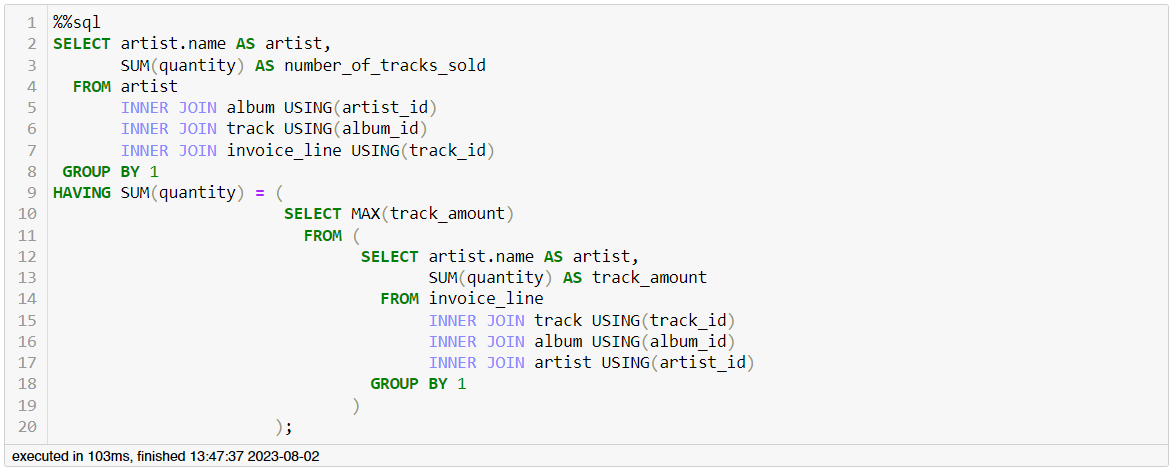

Но я могу писать запросы в любом стиле, ведь главное содержание, а не форма, тут уж по договоренности с коллегами.

Далее собственно упражнения:

In [30]:
# вывести средний доход среди всех клиентов

pg_management_query = PostgresManagement(db_args)

query = """
SELECT AVG(AMT_INCOME_TOTAL) AS average_income
  FROM application_train_test;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,average_income
0,170116.05986


In [31]:
# вывести минимальный и максимальный возраст среди всех клиентов
pg_management_query = PostgresManagement(db_args)

query = """
SELECT ABS(MIN(DAYS_BIRTH)) AS max_age_days,
       ABS(MAX(DAYS_BIRTH)) AS min_age_days,
       FLOOR(ABS(MIN(DAYS_BIRTH)) / 365.24) AS max_age_years,
       FLOOR(ABS(MAX(DAYS_BIRTH)) / 365.24) AS min_age_years
  FROM application_train_test;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,max_age_days,min_age_days,max_age_years,min_age_years
0,25229,7338,69.0,20.0


In [32]:
# вывести количество мужчин и женщин

pg_management_query = PostgresManagement(db_args)

query = """
SELECT CODE_GENDER,
       COUNT(CODE_GENDER) 
  FROM application_train_test
 GROUP BY CODE_GENDER;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,code_gender,count
0,F,235126
1,M,121125
2,XNA,4


In [33]:
# вывести общую сумму, количество и среднюю сумму, запрошенную клиентами в кредит с авто и без

pg_management_query = PostgresManagement(db_args)

query = """
SELECT SUM(AMT_credit) AS total,
       COUNT(AMT_credit) AS number_of_loans,
       AVG(AMT_credit) AS avg_loan_amount
  FROM application_train_test
 GROUP BY FLAG_OWN_CAR;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,total,number_of_loans,avg_loan_amount
0,1.304037e+11,235235,554317.381867
1,7.900276e+10,121020,652786.569683


In [34]:
# вывести доли клиентов с различным образованием

pg_management_query = PostgresManagement(db_args)

query = """
SELECT NAME_EDUCATION_TYPE,
       1.0 * COUNT(NAME_EDUCATION_TYPE) / (
                                           SELECT COUNT(NAME_EDUCATION_TYPE) 
                                             FROM application_train_test
                                          ) AS proportion
  FROM application_train_test
 GROUP BY NAME_EDUCATION_TYPE;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,name_education_type,proportion
0,Academic degree,0.000575
1,Higher education,0.245271
2,Incomplete higher,0.033687
3,Lower secondary,0.012045
4,Secondary / secondary special,0.708422


In [35]:
# подсчитать количество полных лет для клиентов, у которых есть во владении автомобиль и недвижимость.
# вывести топ 10 по возрастанию

pg_management_query = PostgresManagement(db_args)

query = """
SELECT FLOOR(ABS((DAYS_BIRTH)) / 365.24) AS age
  FROM application_train_test
 WHERE FLAG_OWN_CAR = 'Y' AND FLAG_OWN_REALTY = 'Y'
 ORDER BY 1
 LIMIT 10;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,age
0,20.0
1,20.0
2,21.0
3,21.0
4,21.0
5,21.0
6,21.0
7,21.0
8,21.0
9,21.0


In [36]:
# вывести тех клиентов, у кого доход на одного члена семьи в два раза больше, чем в среднем на одного члена семьи по выборке

pg_management_query = PostgresManagement(db_args)

query = """
SELECT SK_ID_CURR,
       AMT_INCOME_TOTAL	/ CNT_FAM_MEMBERS AS income_per_family_member
  FROM application_train_test
 WHERE AMT_INCOME_TOTAL	/ CNT_FAM_MEMBERS > 2 * (
                                                 SELECT AVG(AMT_INCOME_TOTAL / CNT_FAM_MEMBERS)
                                                   FROM application_train_test
                                                );
""" 
with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,sk_id_curr,income_per_family_member
0,100002,202500.0
1,100033,270000.0
2,100053,202500.0
3,100070,540000.0
4,100079,225000.0
...,...,...
27728,456184,270000.0
27729,456189,270000.0
27730,456209,202500.0
27731,456228,270000.0


In [37]:
# вывести клиентов старше 60 лет по которым нет данных в bureau

pg_management_query = PostgresManagement(db_args)

query = """
SELECT application_train_test.SK_ID_CURR,
       FLOOR(ABS((DAYS_BIRTH)) / 365.24) AS age
  FROM application_train_test
       LEFT JOIN bureau ON application_train_test.SK_ID_CURR = bureau.SK_ID_CURR
 WHERE ABS((DAYS_BIRTH)) / 365.24 > 60 AND bureau.SK_ID_CURR IS NULL;
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

print(df.sort_values('sk_id_curr'))

# есть еще один более веселый способ получить ту же информацию через NOT EXISTS (ряды будут в другом порядке)
pg_management_query = PostgresManagement(db_args)

query = """
SELECT application_train_test.SK_ID_CURR,
       FLOOR(ABS((DAYS_BIRTH)) / 365.24) AS age
  FROM application_train_test       
 WHERE ABS((DAYS_BIRTH)) / 365.24 > 60 AND NOT EXISTS (
                                                       SELECT *
                                                         FROM bureau
                                                        WHERE application_train_test.SK_ID_CURR = bureau.SK_ID_CURR
                                                      );
"""

with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

print(df.sort_values('sk_id_curr'))

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

      sk_id_curr   age
2016      100118  61.0
2017      100236  63.0
5629      100273  63.0
5309      100287  68.0
4082      100413  62.0
...          ...   ...
5873      455825  60.0
5874      455832  68.0
2691      455901  60.0
1158      456068  63.0
2500      456169  62.0

[5933 rows x 2 columns]
Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

      sk_id_cur

In [38]:
# вывести женщин, у которых в истории bureau было больше двух кредитов, просроченных на 61 день и более
# отсортировать в порядке убывания по кол-ву таких кредитов

pg_management_query = PostgresManagement(db_args)

query = """
SELECT application_train_test.SK_ID_CURR,
       COUNT('SK_ID_BUREAU')
  FROM application_train_test
       INNER JOIN bureau ON application_train_test.SK_ID_CURR = bureau.SK_ID_CURR
 WHERE CODE_GENDER = 'F' AND CREDIT_DAY_OVERDUE >= 61
 GROUP BY 1
HAVING COUNT('SK_ID_BUREAU') > 2
 ORDER BY 2 DESC
""" 
with pg_management_query as (conn, cursor):
    df = pg_management_query.get_df_from_query(conn, cursor, query)

df

Postgres server information
{'user': 'cft_shift_user', 'channel_binding': 'prefer', 'dbname': 'home_credit', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



,sk_id_curr,count
0,264144,5
1,142384,4
2,374345,3
3,375724,3
4,431820,3
5,114166,3
6,436084,3
7,337741,3


In [39]:
# по данным из bureau (БКИ) расчитать долю просрочки в активных займах для каждого клиента
# вывести топ 7 мужчин с наибольшей суммой просрочки, указав для них, помимо прочего,
# сумму активных кредитов и суммы всех кредитов (активных и закрытых).


### Генерация 5 фич для будущего обучения модели